In [1]:
# load all training data (including missing data)

import numpy as np
from facial_data import load_all_training_data

X_train, y_train = load_all_training_data('training.csv')

# transform X_train, y_train to numpy arrays
X_train = np.array(X_train).reshape((-1, 96, 96, 1))
y_train = np.array(y_train)

In [2]:
n_missing = np.count_nonzero(np.count_nonzero(y_train==-1, axis=1))
print('There are', n_missing, 'faces with missing keypoints')

There are 4909 faces with missing keypoints


In [3]:
# clear previous gpu memory
import gc
from keras import backend as K
K.clear_session()
gc.collect()

Using TensorFlow backend.


0

In [4]:
# load pre-trained model
# preprocess_mean = 120.75424622708769
# preprocess_std = 58.64658640897404

import numpy as np
from keras.models import load_model

simple_cnn_model = load_model('simple_cnn_model.h5')
preprocess_mean = 120.75424622708769
preprocess_std = 58.64658640897404

In [5]:
# predict using pre-trained model

X_train = (X_train - preprocess_mean) / preprocess_std
y_pred = simple_cnn_model.predict(X_train)

In [6]:
# fill missing keypoints with y_pred

y_train_filled = y_train
missing_indices = np.nonzero(y_train_filled==-1)
for i in range(len(missing_indices[0])):
    row, col = missing_indices[0][i], missing_indices[1][i]
    y_train_filled[row, col] = y_pred[row, col]

n_missing = np.count_nonzero(np.count_nonzero(y_train_filled==-1, axis=1))
print('There are', n_missing, 'faces with missing keypoints')

There are 0 faces with missing keypoints


In [7]:
# restore X_train
X_train = X_train * preprocess_std + preprocess_mean
y_train = y_train_filled

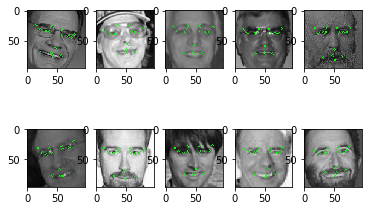

In [8]:
# 畫幾張圖來瞧瞧

import cv2
import copy
from matplotlib import pyplot as plt
%matplotlib inline

some_images_to_show = []
for k in range(10):
    test_img = X_train[6000+k].reshape((96, 96)).astype('uint8')
    test_img = np.stack([test_img]*3, axis=2)
    plt.subplot(2, 5, k+1)
    for i in range(15):
        x = int(y_train[6000+k][2*i])
        y = int(y_train[6000+k][2*i+1])
        cv2.circle(test_img, center=(x,y), radius=2, color=(0, 255, 0), thickness=1)
    plt.imshow(test_img)


In [9]:
# pre-process

# 取n_train出來當training data, 剩下的當validation
n_train = len(X_train) - 1
n_valid = len(X_train) - n_train

X_valid = X_train[n_train:]
y_valid = y_train[n_train:]
X_train = X_train[0:n_train]
y_train = y_train[0:n_train]

# zero-centering: minus mean
preprocess_mean = np.mean(X_train)
X_train -= preprocess_mean
X_valid -= preprocess_mean

# normalization: divided by standard deviation
preprocess_std = np.std(X_train)
X_train /= preprocess_std
X_valid /= preprocess_std

# for y: no need to do any pre-process

print('X_train.shape =', X_train.shape)
print('y_train.shape =', y_train.shape)
print('X_valid.shape =', X_valid.shape)
print('y_valid.shape =', y_valid.shape)
print('preprocess_mean =', preprocess_mean)
print('preprocess_std =', preprocess_std)

X_train.shape = (7048, 96, 96, 1)
y_train.shape = (7048, 30)
X_valid.shape = (1, 96, 96, 1)
y_valid.shape = (1, 30)
preprocess_mean = 124.8435261505431
preprocess_std = 59.351240102347525


In [18]:
# clear previous gpu memory
import gc
from keras import backend as K
K.clear_session()
gc.collect()

2559

In [19]:
simple_cnn_model2 = load_model('simple_cnn_model.h5')

# hist = simple_cnn_model2.fit(X_train, y_train, batch_size=16, epochs=10, validation_split=0.2)
# hist = simple_cnn_model2.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_valid, y_valid))
hist = simple_cnn_model2.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_train, y_train))

Train on 7048 samples, validate on 7048 samples
Epoch 1/30
7048/7048 [==============================] - 10s 1ms/step - loss: 3.6958 - val_loss: 3.1080
Epoch 2/30
7048/7048 [==============================] - 10s 1ms/step - loss: 3.3192 - val_loss: 10.8157
Epoch 3/30
7048/7048 [==============================] - 10s 1ms/step - loss: 3.3163 - val_loss: 3.2717
Epoch 4/30
7048/7048 [==============================] - 10s 1ms/step - loss: 3.0415 - val_loss: 2.9147
Epoch 5/30
7048/7048 [==============================] - 10s 1ms/step - loss: 2.9070 - val_loss: 2.6272
Epoch 6/30
7048/7048 [==============================] - 10s 1ms/step - loss: 2.9415 - val_loss: 2.2864
Epoch 7/30
7048/7048 [==============================] - 10s 1ms/step - loss: 2.7201 - val_loss: 2.2780
Epoch 8/30
7048/7048 [==============================] - 10s 1ms/step - loss: 2.6281 - val_loss: 2.7042
Epoch 9/30
7048/7048 [==============================] - 10s 1ms/step - loss: 2.6526 - val_loss: 2.6304
Epoch 10/30
7048/7048 [=

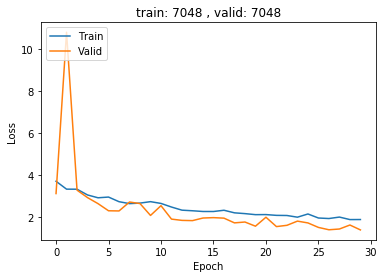

In [20]:
# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('train: 7048 , valid: 7048')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [22]:
# save the model to file

simple_cnn_model2.save('simple_cnn_model2.h5')

In [23]:
# load test data

from facial_data import load_test_data, load_feature_dictionary

feature_dict = load_feature_dictionary()

X_test = load_test_data('test.csv')
X_test = np.array(X_test).reshape((-1, 96, 96, 1))
print('X_test.shape = ', X_test.shape)

# pre-process
X_test -= preprocess_mean
X_test /= preprocess_std

X_test.shape =  (1783, 96, 96, 1)


In [24]:
# predict test data

y_pred = simple_cnn_model2.predict(X_test)
print('y_pred.shape = ', y_pred.shape)

y_pred.shape =  (1783, 30)


In [25]:
# write output 

from facial_data import write_output

write_output('output2.csv', y_pred)